# Multilingual Toxic Comment Classification (mBERT,XLM-RoBERTA, transformers)

* [Methodology](#1)
* [Transfer learning](#2)
* [TPU detection](#3)
* [Loading the data](#4)
* [mBERT](#5)
> * [Preprocessing](#6)
> * [Build the data pipeline](#7)
> * [Define the model](#8)
> * [Train the model](#9)
> * [Evaluation and submission](#10)
* [XLM-RoBERTa](#11)
> * [Preprocessing](#12)
> * [Build the data pipeline](#13)
> * [Define the model](#14)
> * [Train the model](#15)
> * [Evaluation and submission](#16)

## Methodology <a id="1"></a>

We will try to in-depth describe aspects regarding fine-tuning and training: the model architecture, the experiment setup, hyperparameters choosing and all appropriate specificities.

Fine-tuning both models, mBERT and XLM-RoBERTa, requires a hardware accelerator. That goal will be best achieved by using free access to Kaggle's Tensor Processing Units [TPUs](https://www.kaggle.com/docs/tpu). This design also calls for using Keras API with the TensorFlow backend which implicitly solves the problem with choosing the Deep Learning Framework.

There is a variety of techniques and ready-to-use libraries for fine-tuning mBERT or XLM-RoBERTa. For mBERT, I tried libraries such as [keras-bert](https://github.com/CyberZHG/keras-bert), [tensorflow_hub](https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2) and [transformers](https://github.com/huggingface/transformers) by HuggingFace. The latter was used for XLM-RoBERTa too, though there are concise approaches which use the PyTorch backend, but I will pass that due to TensorFlow choosing. Therefore, I came up with the implementation based on transformers library for fine-tuning both models due to possibility of making a similar architecture with the same hyperparameters wherever possible. 

## Transfer Learning <a id="2"></a>

The classical models imply to work with one specific task and certain feature-space after training based on machine learning or deep learning algorithms. The models have to be retrained if we want to change the task or even the domain. \textbf{Transfer learning} is a technique for leveraging the learned knowledge for one task to solve similar ones.

In general, the transfer learning workflow for the classification task is the following:

**1. Load a pre-trained model** <br>
**2. Freeze the layers to save the learned knowledge, patterns for the previous task**
**3. Exclude the existed head (classifier) and add a new head with an appropriate number of hidden units and activation function** <br>
**4. Train the model on a new dataset** <br>

I use mBERT and XLM-RoBERTa as pre-trained models and they both are [Transformer](https://arxiv.org/abs/1706.03762) based language models .

- **Transformer layer** The basic component for both models is the Transformer layer. The classical Transformer consists of encoder and decoder modules, and connections between them. These modules are a bunch of encoders and decoders respectively. Models like mBERT or XLM-R have only encoder module, and we focus on that. The Transformer layer (encoder) has two components:

    - **Self-Attention** which answers a question: "How relevant i-th word in the sentence to other words in the same sentence?" For example, we have the following sentence:
 <center><code>”The cow can't cross the street because it is too tired”.</code></center> <br> 
 What does “it” in this sentence refer to? Is it referring to the cow or to the street? It’s an elementary question to a human, but not as elementary to a machine.
When the model is processing the word “it”, self-attention allows to associate “it” with “cow”. As the model processes each position in the sentence, self-attention is looking at other positions in the input sequence and identifying the relations between them. Thus, the output for each word is a vector which represents the contextual relationship between other words in the sentence.

    - **Feed-Forward** is just a simple feed-forward neural network applied to each attention vector. This network is used in practice to transform the attention vector into a form that digestible by the next encoder in the module.
  
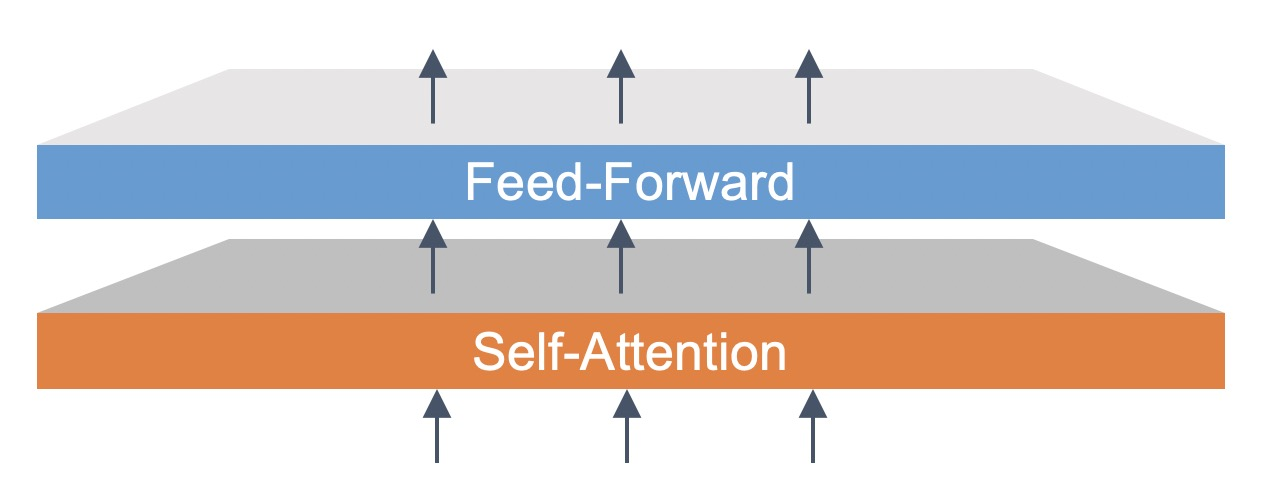



### Helper Functions

We define a single function for building the transformer model in order to design the same fine-tuning architecture for both cases. The transformer layers are created by loading the pre-trained models:
- **bert-base-multilingual-cased** - mBERT
- **jplu/tf-xlm-roberta-large** - XLM-RoBERTa

The dense layer is added on top of the transformer layer. For solving the binary classification task, it has only one output neuron with the sigmoid activation function: 

\begin{equation*} 
\hat{y_{}}(z) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-\theta^Tz} },
\end{equation*}

where $\theta$ is a weights matrix of the last layer and $z$ is an output of the previous layer.

The binary cross-entropy function is our objective for minimizing:

\begin{equation*} 
J(y_{i},\hat{y_{i}}) = -\frac{1}{N}\sum_{i=1}^{N} \left [ y_{i}\ln(\hat{y_{i}}) + (1-y_{i})\ln(1-\hat{y_{i}}) \right ],
\end{equation*} 

where $y_{i}$ and $\hat{y_{i}}$ are real and predicted toxic class for a comment $i$ in the batch respectively, $N$ is a batch size.

For updating network weights, we use the [Adam optimization algorithm](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) as a recommendation from [the original paper](https://arxiv.org/abs/1810.04805) instead of the regular stochastic gradient descent.

In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    # changed from 1e-5 to 3e-5
    return model

The main evaluation metric is an area under the ROC curve (ROC AUC). 

In [ ]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import os
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

## TPU detection <a id="3"></a>

The first step is to detect and initialize the TPU cores in the Kaggle Notebook. For this purpose, we should flip the **Accelerator** switch to the TPU in a notebook and bear in mind the time limits for using them (up to 30 hours per week).

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

## Loading the data <a id="4"></a>

In [ ]:
DATA_PATH =  "../input/jigsaw-multilingual-toxic-comment-classification"

In [ ]:
wiki_toxic_comment_data = "jigsaw-toxic-comment-train.csv"
toxic_unintended_data = "jigsaw-unintended-bias-train.csv"
valid_data = "validation.csv"
test_data = "test.csv"
sub_sample = "sample_submission.csv"


wiki_toxic_comment = pd.read_csv(os.path.join(DATA_PATH, wiki_toxic_comment_data))
toxic_unintended = pd.read_csv(os.path.join(DATA_PATH, toxic_unintended_data))
valid = pd.read_csv(os.path.join(DATA_PATH, valid_data))
test = pd.read_csv(os.path.join(DATA_PATH, test_data))
sub = pd.read_csv(os.path.join(DATA_PATH, sub_sample))


In [ ]:
# Round toxic values
toxic_unintended.toxic = toxic_unintended.toxic.round().astype(int) 

toxic = len(toxic_unintended[['comment_text', 'toxic']].query('toxic==1'))
# Combine wiki_toxic_comment with a subset of toxic_unintended
train1 = pd.concat([
    wiki_toxic_comment[['comment_text', 'toxic']],
    toxic_unintended[['comment_text', 'toxic']].query('toxic==1'),
    toxic_unintended[['comment_text', 'toxic']].query('toxic==0').sample(n = (toxic + (toxic // 3) ), random_state = 42)
])
train1.info()

We try to define models and choose similar hyperparameters for them. That's why the following processes are quite similar for both of them.

# mBERT <a id="5"></a>

In this section, we focus on fine-tuning the model for the binary classification task. In general, the mBERT is designed to solve a variety of NLP tasks such as sentence pair or single sentence classification tasks, question answering tasks, etc. For each task we have a different structure of inputs and outputs, to make it clear, Figure below shows the mBERT configuration for the toxic classification. We can see that the first input token is a special [CLS] token which stands for the classification task and because of which the model outputs only the first position. It should be noted that for non-classification tasks, there will be more output positions. 

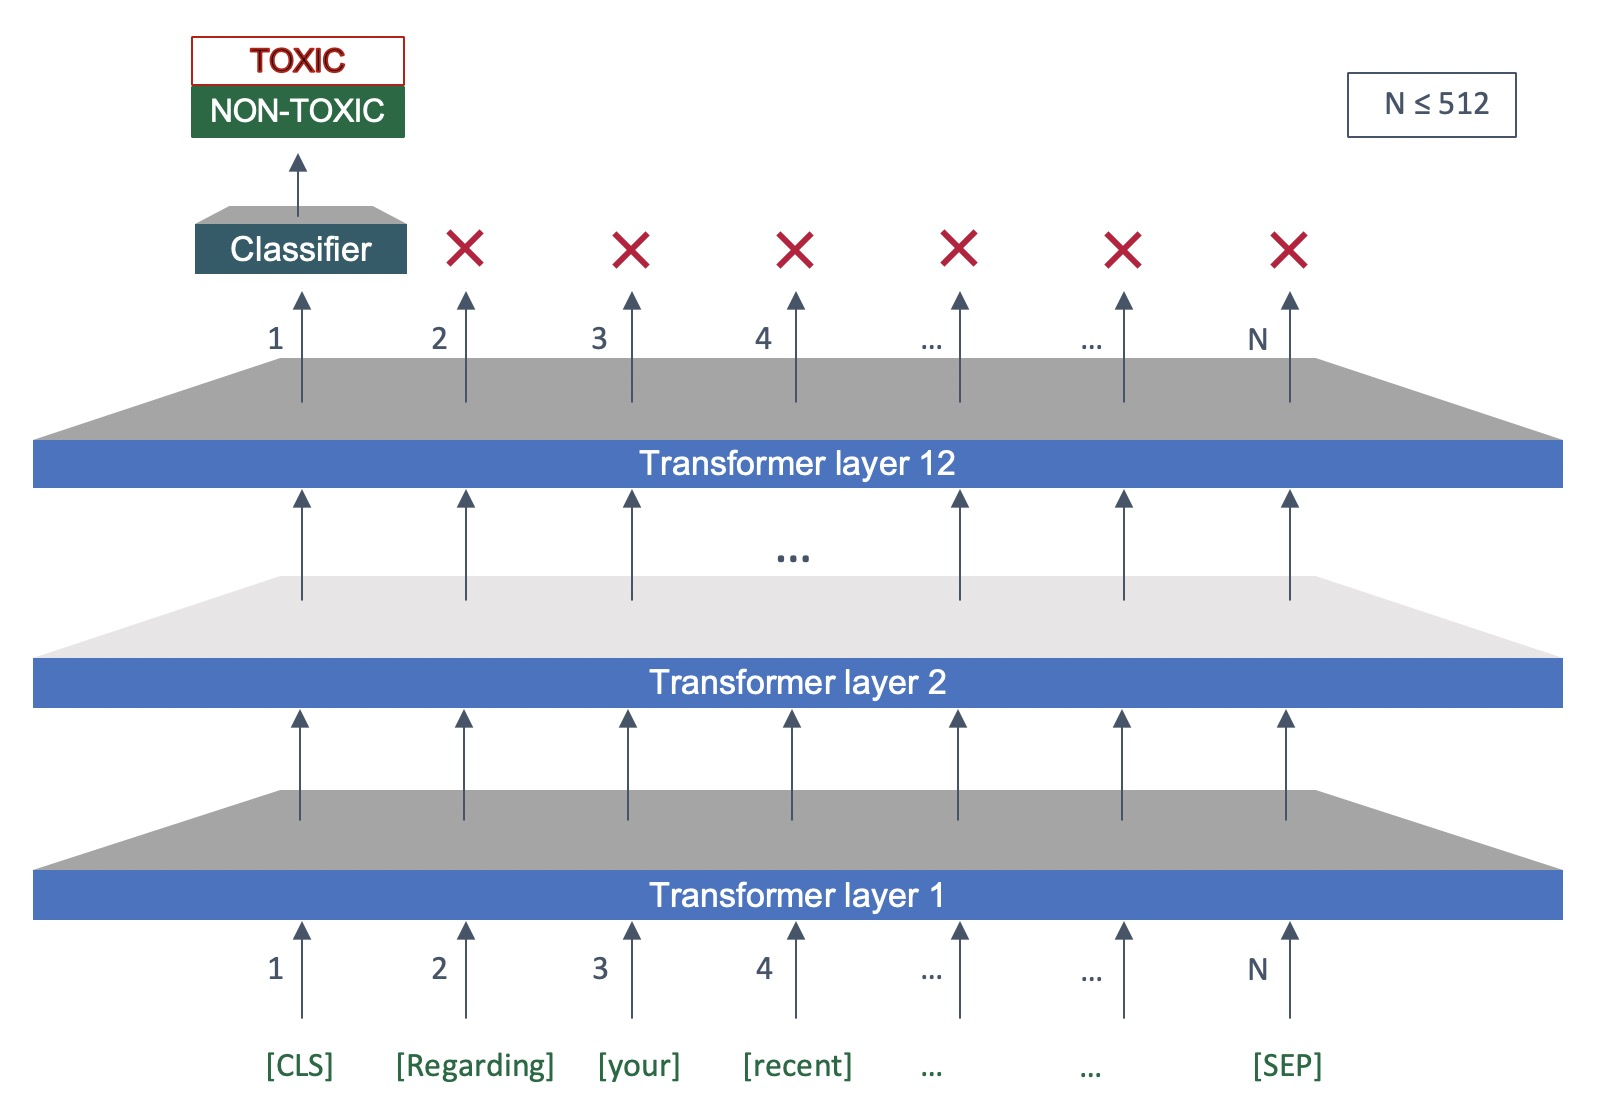

Figure demonstrates the mBERT model which has twelve Transformer layers (encoders). Further, each output position is a vector of size 768 hidden units. The vocabulary size is extended in comparison with monolingual BERT from 30K to 110K tokens. A total number of parameters is 172M. The maximum sequence length is 512 tokens.

In [ ]:
# Configuration
EPOCHS = 2
BATCH_SIZE_PER_CORE = 64
BATCH_SIZE = BATCH_SIZE_PER_CORE * strategy.num_replicas_in_sync
MAX_LEN = 200

- **Epochs**: We tried a different number of epochs and found that more than 2 epochs lead to the overfitting problem, thus 2 epochs are enough to prevent that.
- **Batch size**: The following formula is used for setting the batch size: <br><br>
\begin{equation*}
batch\_size = batchsize\_per\_core \cdot NUMBER\_OF\_TPU\_CORES
\end{equation*} <br>
where  $batch\_size\_per\_core$ is a hyperparameter which we have set to 64, while $NUMBER\_OF\_TPU\_CORES$ is a constant which equals to 8 cores. The constant is need to distribute data evenly among cores. I tried increasing $batch\_size\_per\_core$, as recommended in the official documentation, to reduce the training time by loading more the TPU, but got a resource exhausted error for more than 64 units, which means a lack of random-access memory.

- **Sequence length**: The median comment length is 203 tokens, and because of that fact, we can minimize the truncation and padding during tokenizing. Also, we empirically found that 200 tokens are an optimal sequence length.
 
- **Learning rate**: The learning rate is fixed to 3e-5, as recommended in [the original BERT paper](https://arxiv.org/abs/1810.04805).


## mBERT: Preprocessing <a id="6"></a>

We will describe in detail the internal mBERT techniques: from raw text to “ready-to-train” form.
As for any pre-trained model, developers provide not only the weights matrix for the complex neural network architecture, but preprocessing methods and the network hyperparameters which were used during training. Most often the authors contribute the vocabulary and the tokenizer for NLP task-agnostic models such as mBERT or XLM-RoBERTa which can be fine-tuned for any related downstream tasks.
Crucially, the preprocessing phase should be the same as for original mBERT pre-training data to avoid mismatch.
The mBERT tokenization contains three main steps:
- **Normalization.** The raw text is transformed to lowercase, each whitespace is converted to one space, and accent markers are removed. The reduction of accent markers potentially changing word meaning for some languages. This is a deliberate step, the authors state that this step significantly decreases the vocabulary size. A trade-off has to be settled by the strong context-dependence of mBERT.
<center><code>Example: “Martin's glasses.” $\rightarrow$ “martin's glasses.”</code></center>

- **Punctuation splitting.** Both-side splitting all punctuation symbols (adding whitespace on both sides). The punctuation symbol is Unicode punctuation characters or any non-number/letter/space ASCII characters.
<center><code>Example: “martin's glasses.” -> “martin ' s glasses . ”</code></center>

- **WordPiece tokenization.** This step applies whitespace tokenization and for each token. [WordPiece](https://static.googleusercontent.com/media/research.google.com/ja//pubs/archive/37842.pdf) is a word segmentation algorithm and needed to handle Out-Of-Vocabulary (OOV) or rare words. The core idea for the word segmentation algorithm is to give unique ids for most frequent words, while others are broken down into subword units with the best meaning preserve. The WordPiece algorithm operates as follows: any OOV or rare word will be decomposed into characters which will be merged to create the most suitable subword units. The subword units are chosen based on the increasing log-likelihood of a unigram model trained on the training data. It is worth noting that the hashed subwords (e.g. \#\#aff) are already in mBERT vocabulary.
<center><code>Example: “unaffable”~$\rightarrow$~“un”, “\#\#aff”, “\#\#able”</code></center> 


There are still practices that should be mentioned. The maximum possible sequence length for mBERT and XLM-RoBERTa inputs is 512 tokens. I tried different sequence lengths for text comments and found 200 tokens as an optimal to avoid lots of padding or truncation on the other side. <br> <br>
The mBERT model is designed to solve a variety of NLP tasks, for this reason for indicating the classification we add [CLS] and [SEP] tokens at the beginning and the end respectively. 



In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
# First load the real tokenizer 
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased') 
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:
%%time
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

## mBERT: Build the data pipeline <a id="7"></a>

The Kaggle Notebook environment provides the TPU accelerator for training with 8 computational cores and only 4 CPU cores for supporting processes such as the data pipeline. This poses the TPU data starvation problem because the TPU core is a dramatically fast matrix computer and CPU basically can't provide a new batch of training data on time. To mitigate this issue and properly load the computing units we use the TensorFlow Dataset type which allows building a highly optimized, asynchronous data pipeline. 

We want the TPU to be fully loaded and the CPU to process the batches immediately, for that we use a prefetching technique at the end of the pipeline. This will always prepare the necessary number of batches(buffer) for the next need. We use automatically calculated buffer size based on batch size. The technique is used for training and validation datasets.

In [ ]:
#for prefetching
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(len(x_train))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

## mBERT: Define the model <a id="8"></a>

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFBertModel
        .from_pretrained('bert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

## mBERT: Train the model <a id="9"></a>

The final training process compromises two stages. The first stage includes training on the English dataset and validating on the relatively small multilingual dataset which contains Spanish, Italian, and Turkish. The second stage consists of training with the same hyperparameters on the validation dataset to expand the understanding of the toxic comments domain by non-English languages.
 
At first, the models were trained only on the English dataset, but after a while, it was investigated that just due to using validation data for additional training, we could strongly increase the results for both models up to 0.06 ROC AUC score. 

Assuming the models were pre-trained the same way, we use the same hyperparameters for an honest comparison. It should be noted that hyperparameters were selected based on mBERT, but XLM-RoBERTa showed the best result on them every time.

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

## mBERT: Evaluation and submission <a id="10"></a>

In [ ]:
scores = model.predict(valid_dataset)
print("Auc: %.2f%%" % (roc_auc(scores,y_valid)*100))

In [ ]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

---

# XLM-RoBERTa <a id="11"></a>

XLM-R transformer language model’s architecture has two modifications namely XLM-RoBERTa-Base and XLM-RoBERTa-Large which have been built with a different set of parameters. Initially, XLM-RoBERTa-Base has been assigned having approximately 270M parameters with 12 Transformer layers, 768 hidden units (in the context of Recurrent Neural Networks). In contrast, the XLM-RoBERTa-Large version has extended architecture with tuned on 550M parameters with 24 Transformer layers and 1024 hidden units. The vocabulary is much larger than mBERT's one, 250K tokens for Base and Large versions.

In comparing to mBERT, XLM-R shows significantly higher results on multilingual tasks with low-resource languages. In the Facebook AI team’s research on the XNLI (Cross-lingual Natural Language Inference) dataset, XLM-R outperformed by 5.1% average accuracy, whereas on F1-measure (weighted harmonic mean of the test’s precision and recall) has been improved by 2.42% on Named Entity Recognition task and [demonstrated](https://arxiv.org/abs/1911.02116) higher F1-score convergence on Cross-lingual Question Answering.

A $batch\_size\_per\_core$ hyperparameter we set to 32. I tried increasing it, as recommended in the official Kaggle documentation, to reduce the training time by loading more the TPU, but got a resource exhausted error for more than 32 units, which means a lack of random-access memory.

In [ ]:
# Configuration
EPOCHS = 2
BATCH_SIZE_PER_CORE = 32
BATCH_SIZE = BATCH_SIZE_PER_CORE * strategy.num_replicas_in_sync
MAX_LEN = 200

## XLM-RoBERTa: Preprocessing <a id="12"></a>

Instead of WordPiece, XLM-RoBERTa uses [SentencePiece](https://github.com/google/sentencepiece) tokenizer.

For classification task we add $<s>$ and $</s>$ tokens at the beginning and the end respectively. 

In [ ]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [ ]:
# Load the tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-large')

In [ ]:
%%time 

x_train = regular_encode(train1.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

## XLM-RoBERTa: Build the data pipeline <a id="13"></a>

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(len(x_train))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

## XLM-RoBERTa: Define the model <a id="14"></a>

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers
        .TFAutoModel.from_pretrained('jplu/tf-xlm-roberta-large')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

## XLM-RoBERTa: Train the model <a id="15"></a>

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

## XLM-RoBERTa: Evaluation and submission <a id="16"></a>

In [ ]:
scores = model.predict(valid_dataset)
print("Auc: %.2f%%" % (roc_auc(scores,y_valid)*100))

In [ ]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)